In [ ]:
#utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import pprint as pp


#text processing & sentiment analysis
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

#from afinn import Afinn
import unicodedata as ud
import camel_tools as ct
from nltk.stem.isri import ISRIStemmer
from ar_wordcloud import ArabicWordCloud
import time

#model
from textblob import TextBlob

from sklearn.metrics import classification_report, accuracy_score
from camel_tools.dialectid           import DialectIdentifier
from camel_tools.utils.normalize     import normalize_alef_maksura_ar
from camel_tools.utils.normalize     import normalize_alef_ar
from camel_tools.utils.normalize     import normalize_teh_marbuta_ar
from camel_tools.utils.normalize     import normalize_unicode
from camel_tools.utils.dediac        import dediac_ar
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
import os
os.environ["CAMELTOOLS_DATA"] = "~/.camel_tools"
from camel_tools.tokenizers.word     import simple_word_tokenize
from camel_tools.disambig.mle        import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer
from camel_tools.sentiment           import SentimentAnalyzer

import arabicstopwords.arabicstopwords as stp

In [ ]:
print(os.getcwd())

In [ ]:

df1_tweets = pd.read_csv('tweet_data_by_day.csv', index_col=0)
df1_tweets = df1_tweets[ df1_tweets['text'].str.startswith('RT') == False ]

#df1_tweets = df1_tweets.head(100)

df2_tweets = pd.read_csv('tweet_data_by_day_post_omicron.csv', index_col=0)
df2_tweets = df2_tweets[ df2_tweets['text'].str.startswith('RT') == False ]

#df2_tweets = df2_tweets.head(100)

In [ ]:
print(len(df1_tweets))
df1_tweets.head()
# df1_tweets.sample(1000)

In [ ]:
print(len(df2_tweets))
df2_tweets.head()
# df2_tweets.sample(1000)

In [ ]:


# for i in range(0,df1_tweets.size):
#    df1_tweets['text'][i] = normalize_alef_ar(df1_tweets['text'][i]) 

text = 'ﷺ'

sentence = "خبير الأمراض المعدية'أنتوني فاوتشي' يخضع للمساءلة لإتهامه بتمويل تجارب وحشية أجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا"


sent_norm = normalize_unicode(sentence)
print(sent_norm)

print(sentence)

# Normalize alef variants to 'ا'
sent_norm = normalize_alef_ar(sentence)
print(sent_norm)

# Normalize alef maksura 'ى' to yeh 'ي'
sent_norm = normalize_alef_maksura_ar(sent_norm)
print(sent_norm)

# Normalize teh marbuta 'ة' to heh 'ه'
sent_norm = normalize_teh_marbuta_ar(sent_norm)
print(sent_norm)

In [ ]:

sentence = "هَلْ ذَهَبْتَ إِلَى المَكْتَبَةِ؟"
print(sentence)

sent_dediac = dediac_ar(sentence)
print(sent_dediac)

In [ ]:
# from camel_tools.tokenizers.word import simple_word_tokenize

# sentence = "هَلْ ذَهَبْتَ إِلَى المَكْتَبَةِ؟"
# print(sentence)

# sent_split = simple_word_tokenize(sentence)
# print(sent_split)

In [ ]:


# First, we need to load a morphological database.
# Here, we load the default database which is used for analyzing
# Modern Standard Arabic. 
db = MorphologyDB.builtin_db()

analyzer = Analyzer(db)

analyses = analyzer.analyze('موظف')

# for analysis in analyses:
#     print(analysis, '\n')

In [ ]:

# The tokenizer expects pre-tokenized text
sentence = simple_word_tokenize("خبير الأمراض المعدية'أنتوني فاوتشي' يخضع للمساءلة لإتهامه بتمويل تجارب وحشية أجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا")
print(sentence)

# Load a pretrained disambiguator to use with a tokenizer
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# Without providing additional arguments, the tokenizer will output undiacritized
# morphological tokens for each input word delimited by an underscore.
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok')
tokens = tokenizer.tokenize(sentence)
print(tokens)

# By specifying `split=True`, the morphological tokens are output as seperate
# strings.
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True)
tokens = tokenizer.tokenize(sentence)
print(tokens)

# We can output diacritized tokens by setting `diac=True`
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True, diac=True)
tokens = tokenizer.tokenize(sentence)
print(tokens)

In [ ]:
with open('ar_stopwords.txt', 'r') as file:
    stopwords = file.read()
#print(stopwords)

In [ ]:
from camel_tools.utils.normalize import normalize_unicode
#remove stopwords and all characters that are not arabic letters or # numbers and lemmatize the words
def preprocess_ar(text):
    processedText = []
    
    my_stp = stp.stopwords_list() + [ u'كورونا', u'ان' ]

    # Cnotreate Lemmatizer and Stemmer.
    st = ISRIStemmer()

    for t in text:
        t = ''.join(c for c in t if ud.category(c) == 'Lo' or ud.category(c) == 'Nd' or c == ' ')
   
        commentwords = ''
        for word in t.split():
            # Checking if the word is a stopword.

            if word not in my_stp:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = st.suf32(word)
                    commentwords += (word+' ')
        processedText.append(normalize_unicode(commentwords))
    
    return processedText

In [ ]:
import time
from nltk.stem.isri import ISRIStemmer
import unicodedata as ud

df1_tweets = pd.read_csv('tweet_data_by_day.csv', index_col=0)
print( df1_tweets.size)
df1_tweets = df1_tweets[ df1_tweets['text'].str.startswith('RT') == False ]

#df1_tweets = df1_tweets.head(100)

t = time.time()

# print( df1_tweets.size)
processedtext_ar1 = preprocess_ar( df1_tweets.text )

# my_str=['هذه الجمله فيها كلمة كورو كورو كورو  كورو الان']
#processedtext_ar1 = preprocess_ar(my_str)
# print(processedtext_ar1)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
# print(processedtext_ar)

In [ ]:
import csv

with open('pre_omicron_df.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(processedtext_ar1)


In [ ]:
df2_tweets = pd.read_csv('tweet_data_by_day_post_omicron.csv', index_col=0)
print( df2_tweets.size)
df2_tweets = df2_tweets[ df2_tweets['text'].str.startswith('RT') == False ]

df2_tweets = df2_tweets.head(100)

t = time.time()
processedtext_ar2 = preprocess_ar(df2_tweets.text)

print( df2_tweets.size)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ar_wordcloud import ArabicWordCloud
stopwords = nltk.corpus.stopwords.words('arabic')
stopwords.extend(['كورو','بدون', 'لكم', 'اللي', 'عشان'])
stopwords.append( stopwords)
awc = ArabicWordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples")

plt.figure(figsize=(16,16))

wc_ar = awc.from_text(u''.join(processedtext_ar1))
plt.axis("off")
plt.imshow(wc_ar)
plt.savefig("WC1.png")

# awc = ArabicWordCloud(background_color="white")

In [ ]:
awc = ArabicWordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples")
plt.figure(figsize=(16,16))
wc_ar = awc.from_text(u''.join(processedtext_ar2))
plt.axis("off")
plt.imshow(wc_ar)
plt.savefig("WC2.png")

In [ ]:

did = DialectIdentifier.pretrained()

sentences = [
    'شنو عادي غدد تدمورنها منصجكم قاعدين تلعبون بارواح الناس من لقاح قاعدين تجربونه ع الشعب وعادي ليش ماتاخذونه وتجربونه عليكم و جريمة',
    'وحضرة اللفندي ده واخد انهي لقاح؟'
]

predictions = did.predict(sentences, 'city')
#print(predictions[0].top)
#print([p.top for p in predictions])

predictions = did.predict(sentences, 'country')
#print([p.top for p in predictions])

predictions = did.predict(sentences, 'region')
#print([p.top for p in predictions])

In [ ]:

from datetime import datetime
did = DialectIdentifier.pretrained()
sa = SentimentAnalyzer.pretrained()

t1 = datetime.now()

df1_tweets[ 'Sentiment' ] = df1_tweets['text'].apply( lambda x: sa.predict(  [ x ] )[ 0 ] )
df1_tweets[ 'Label' ]     = df1_tweets['text'].apply( lambda x: did.predict( [ x ] )[ 0 ].top )

loc = pd.read_csv( '/Users/nada/Documents/Nada/diss/csv/locations.csv' );  
df1_tweets = df1_tweets.merge( loc, on ='Label' )

df1_tweets.to_csv('Raw_tweets_plus_sentiments_pre.csv', index = False )

print(datetime.now() - t1)



In [4]:
#create a matrix of sentiments by city
import matplotlib.pyplot as plt
from collections import Counter
import pprint as pp
titles = ['sentiment', 'city', 'country', 'region'] 
sentiment_type = ['positive', 'negative', 'neutral'] 

def build_matrix(sentiments):
    matrix = {}

    for row in sentiments.values.astype(str).tolist():
        if not matrix.get(row[0]):
            matrix[ row[0] ] = {}

        if not matrix[ row[0] ].get( row[1] ) :
            matrix[ row[0] ] [ row[1] ] = {}
            matrix[ row[0] ] [ row[1] ] = 1      
        else:
            matrix[ row[0] ] [ row[1] ] += 1      
            
    return(matrix)

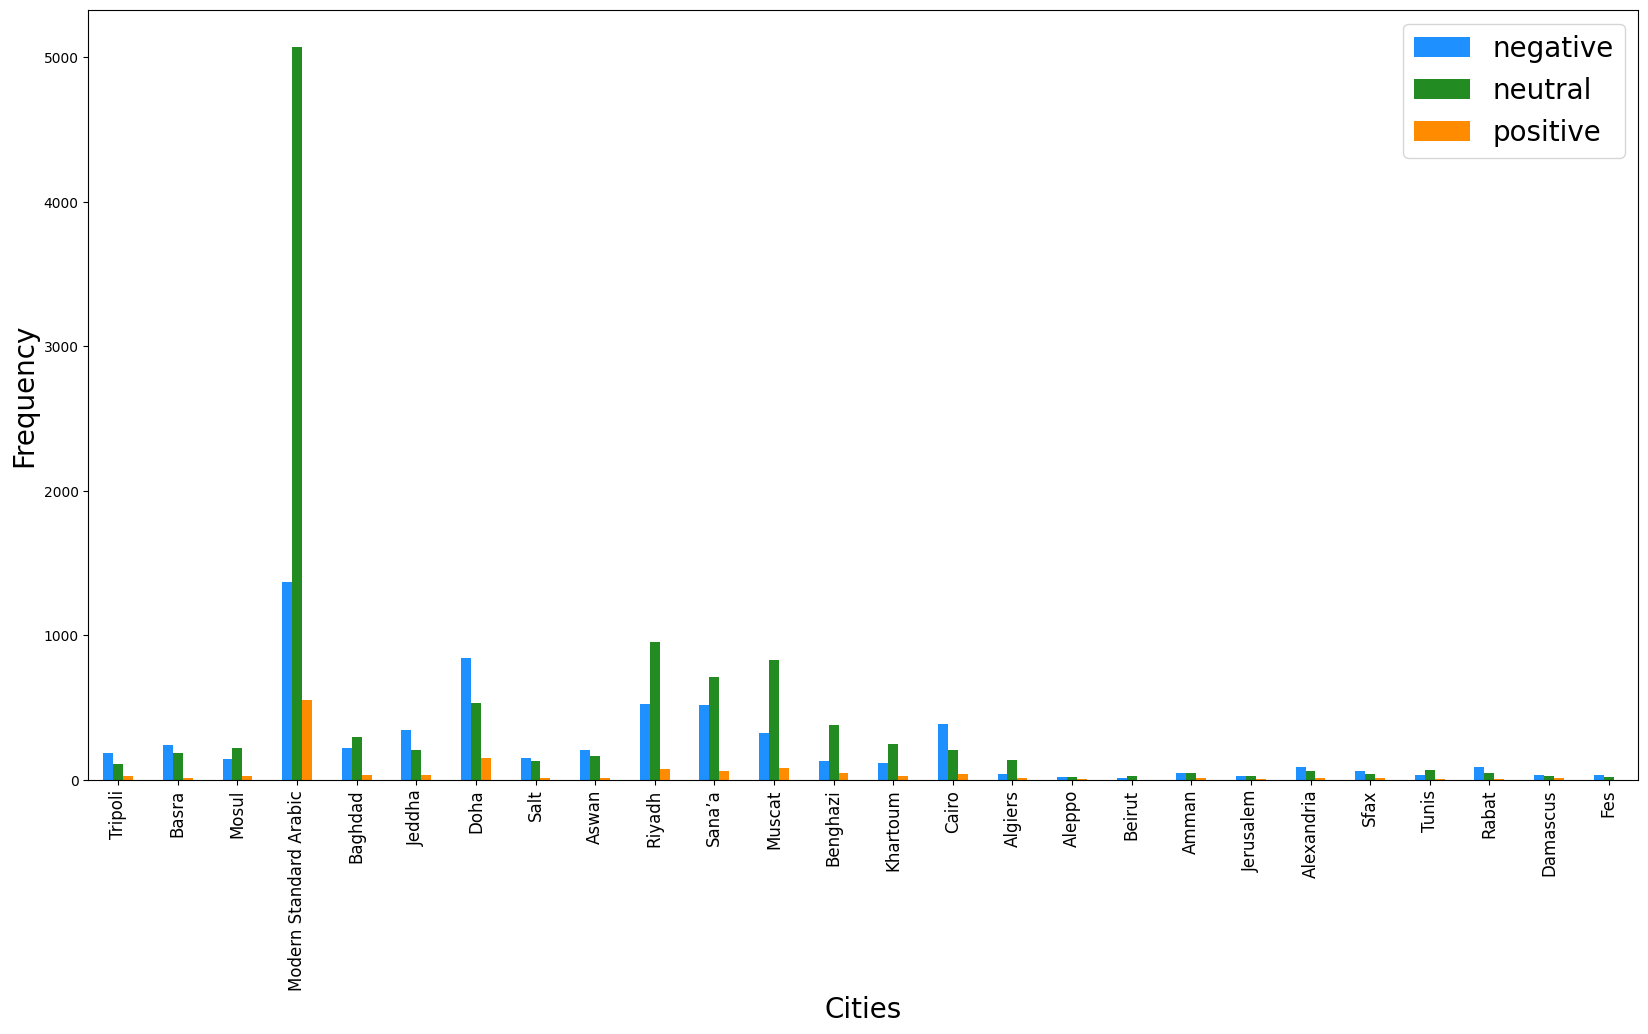

0:00:00.971062


In [5]:
FIGS_PATH='/Users/nada/Documents/GitHub/Design-and-Development-updated/Vaccine_in_Arab_World'

df1_tweets = pd.read_csv('Raw_tweets_plus_sentiments_pre.csv', low_memory=False);


# Creating a data frame using pandas to compare the occurrence of each sentiment by city for the X corpus
from datetime import datetime

df = pd.DataFrame( build_matrix( df1_tweets[['Sentiment','City']] ))

t = datetime.now()
ax= df.plot.bar(color = ('#1E90FF','#228B22', '#FF8C00'), figsize=(20, 10))
ax.set_xlabel('Cities', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=12)
plt.legend(fontsize = 20)
plt.savefig(FIGS_PATH+"/sentiments_by_city_pre.png")
plt.show()

print(datetime.now() - t)

In [ ]:
from datetime import datetime
did = DialectIdentifier.pretrained()
sa = SentimentAnalyzer.pretrained()

t1 = datetime.now()

df2_tweets[ 'Sentiment' ] = df2_tweets['text'].apply( lambda x: sa.predict(  [ x ] )[ 0 ] )
df2_tweets[ 'Label' ]     = df2_tweets['text'].apply( lambda x: did.predict( [ x ] )[ 0 ].top )

loc = pd.read_csv( '/Users/nada/Documents/Nada/diss/csv/locations.csv' );  
df2_tweets = df2_tweets.merge( loc, on ='Label' )

df2_tweets.to_csv('Raw_tweets_plus_sentiments_post.csv', index = False )

print(datetime.now() - t1)


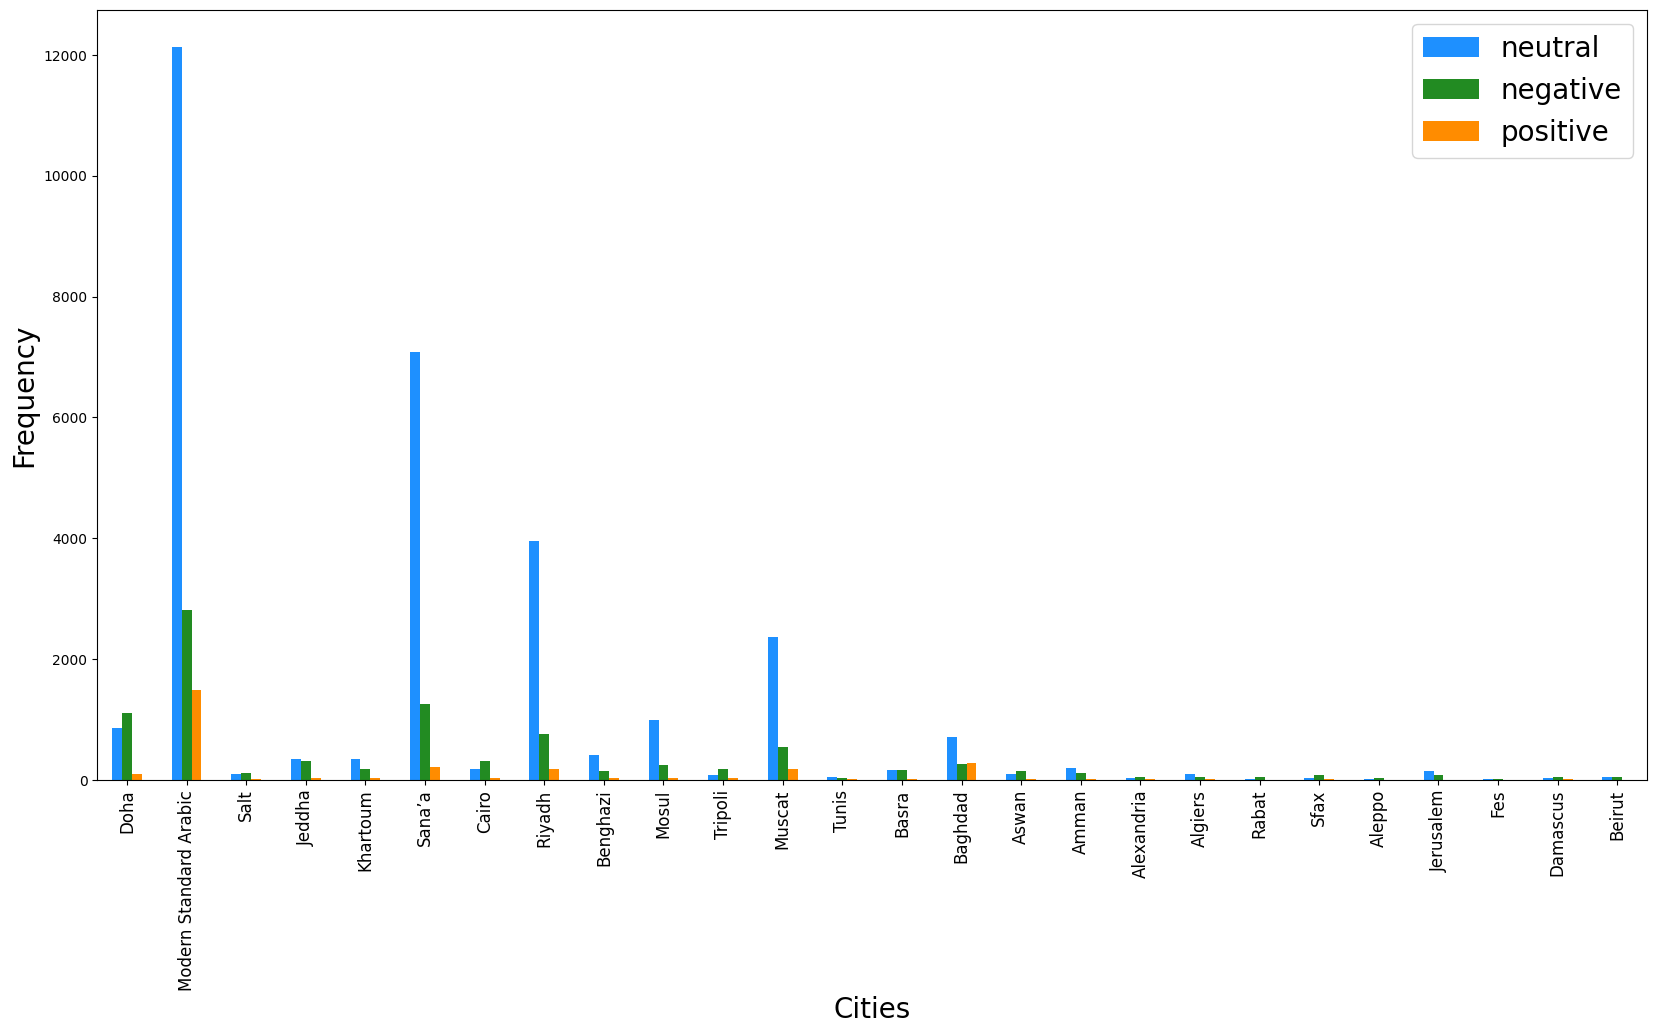

0:00:00.862008


In [6]:
FIGS_PATH='/Users/nada/Documents/GitHub/Design-and-Development-updated/Vaccine_in_Arab_World'

df2_tweets = pd.read_csv('Raw_tweets_plus_sentiments_post.csv', low_memory=False);


# Creating a data frame using pandas to compare the occurrence of each sentiment by city for the X corpus
from datetime import datetime

df = pd.DataFrame( build_matrix( df2_tweets[['Sentiment','City']] ))

t = datetime.now()
ax= df.plot.bar(color = ('#1E90FF','#228B22', '#FF8C00'), figsize=(20, 10))
ax.set_xlabel('Cities', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=12)
plt.legend(fontsize = 20)
plt.savefig(FIGS_PATH+"/sentiments_by_city_post.png")
plt.show()

print(datetime.now() - t)

In [ ]:
sen1 = []
nums = [10009, 13105, 14064, 16699, 16787, 1691, 16915, 17610, 17611 ]
for i in range(16914,len(processedtext_ar1)):
    if i in nums:
        continue
    text = processedtext_ar1[ i ]
    sen1.append([sa.predict(text)[0], did.predict(text, 'city')[0].top, did.predict(text, 'country')[0].top, did.predict(text, 'region')[0].top])
   

In [ ]:
sentiments1 = pd.DataFrame( sen1, columns = ['sentiment', 'city', 'country', 'region' ] )
sentiments1
#sentiments1.to_csv('../Mapping/sentiments1_0_16908_to_18260.csv')


#sentiments1.city.value_counts().plot(kind = 'bar')

In [ ]:
df1_all = pd.concat( [ sentiments1, pd.read_csv('../Vaccine_in_Arab_World/sentiments1_0_to_16908.csv') ] )
df1_all.to_csv('../Mapping/sentiments1.csv')
df1_all

df_all

In [ ]:

did = DialectIdentifier.pretrained()
sa = SentimentAnalyzer.pretrained()


In [ ]:
sen2 = []

nums = [ 609, 2326, 2327, 2955, 2956, 4523, 4524, 4525,7187,7858, 8795, 
         10871, 12531, 12532, 16521, 18575, 24564, 33337, 36830 ]
for i in range(36827,len(processedtext_ar2)):
    if i in nums:
        continue
    text = processedtext_ar2[ i ]
    sen2.append([sa.predict(text)[0], did.predict(text, 'city')[0].top, did.predict(text, 'country')[0].top, did.predict(text, 'region')[0].top])
   


In [ ]:
sentiments2 = pd.DataFrame( sen2, columns = ['sentiment', 'city', 'country', 'region' ] )
sentiments2
#sentiments2.to_csv('../Mapping/sentiments2_36829_to_42337.csv')



In [ ]:
df2_all = pd.concat( [  sentiments2,
                        pd.read_csv('../Vaccine_in_Arab_World/sentiments2__upto_rec_24548.csv') ,
                        pd.read_csv('../Vaccine_in_Arab_World/sentiments2_33336_to_36829.csv') ,
                        pd.read_csv('../Vaccine_in_Arab_World/sentiments2_36829_to_42337.csv') ] )

In [ ]:
df2_all
#df2_all.to_csv('../Mapping/sentiments2.csv')

In [ ]:
sentiments1 = pd.read_csv('../Vaccine_in_Arab_World/sentiments1.csv')
sentiments1

# sentiments2 = pd.read_csv('../Vaccine_in_Arab_World/sentiments2.csv')

In [ ]:

titles = ['sentiment', 'city', 'country', 'region'] 
sentiment_type = ['positive', 'negative', 'neutral'] 

def build_matrix(sentiments):
    matrix = {}

    for row in sentiments.values.astype(str).tolist():
        if not matrix.get(row[0]):
            matrix[ row[0] ] = {}

        if not matrix[ row[0] ].get( row[1] ) :
            matrix[ row[0] ] [ row[1] ] = {}
            matrix[ row[0] ] [ row[1] ] = 1      
        else:
            matrix[ row[0] ] [ row[1] ] += 1      
            
    #pp.pprint(matrix )
    return(matrix)

In [ ]:
# Creating a data frame using pandas to compare the occurrence of each word across all three sentiments
df1 = pd.DataFrame( build_matrix( sentiments1 ))


ax= df1.plot.bar(color = ('#FF8C00', '#228B22','#1E90FF' ), figsize=(20, 10))
#ax= df1.plot.bar(color = ('#FF8C00', '#228B22','#1E90FF' ))
ax.set_xlabel('Cities', fontsize=30)
ax.set_ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=16)
plt.legend(fontsize = 20)

#df_sorted = df.sort_values(sentiments1.value_counts())
#plt.bar('Cities', 'Frequency', data=df_sorted)
#plt.savefig("sentiment_by_city1.png")

plt.show()



In [ ]:
df2 = pd.DataFrame( build_matrix( sentiments2 ))

df2
# order = ['negative', 'neutral', 'positive']
ax= df2.plot.bar(color = ('#1E90FF','#228B22','#FF8C00'), figsize=(20, 10))
ax.set_xlabel('Cities', fontsize=30)
ax.set_ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=16)
plt.legend(fontsize = 20)

plt.savefig("sentiment_by_city2.png")

plt.show()

In [ ]:
words = dict()
for i in range(0,len(processedtext_ar1)):
    for word in processedtext_ar1[i].split(' '):
        if  not words.get(''.join(reversed(word))):
            words[ u''.join(reversed(word)) ] = 1
        else:
            words[ u''.join(reversed(word)) ] += 1
words

In [ ]:
import googletrans
from googletrans import Translator

# new_vocab1 = Counter( counts )


clean_tweets = pd.DataFrame(list(words.keys()), columns=[ 'words'])

#print(clean_tweets.words[0:30])
clean_tweets.words[27]='عابني'
# wc_words = pd.DataFrame(clean_tweets.keys(),columns=['words'])
# wc_words
translator = Translator()

# wc = pd.DataFrame([ "هنا" ,"هناك" ], columns=['words'])
#print(clean_tweets.words[27],translator.translate( clean_tweets.words[27], dest = 'en', src = 'ar' )) 
wc = clean_tweets.words[0:10000].apply(lambda x: translator.translate(x, src='ar', dest='en').text )
#wc


In [ ]:

wc_en = WordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples").generate(''.join(wc))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(wc_en)


# stopwords = set(STOPWORDS)
# #stopwords.update(['truetype', 'home','lebanon','volnteer', 'got', 'email', 'volunteer', 'video', 'let', 'contact','jne','may','pblic','member', 'story', 'abot','find', 'join','lebanese', 'minteshreen', 'national', 'bloc', 'party','donate', 'read', 'become', 'settings', 'site', 'cookie', 'browser', 'setting', 'monir', 'will', 'analytics', 'google', 'click', 'yor', 'website', 'cookies', 'measre', 'sorce', 'plugin', 'https', 'f', 'font', 'null', 'input', 'image', 'mmfidawla', 'aviacookierefused','searchaction', 'function', 'l', 't', 'a','of','the','is', 'an', 'it', 'm', 'by', 'this', 'in', 'on', 's', 'i', 'over', 'and', 'or', 'to'])
# df = pd.DataFrame(wc, index = vocabulary,columns = dicts.keys())



# wordcloud = WordCloud(width=1600, height=800, background_color='green', colormap="Reds", stopwords=stopwords).generate(word_bag[key][0])
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# print (key)
# plt.show()
# # awc = ArabicWordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples")
# # plt.figure(figsize=(16,16))
# # wc_ar = awc.from_text(u''.join(processedtext_ar2))
# # plt.axis("off")
# # plt.imshow(wc_ar)



In [ ]:
# def wordsToDictionary(word_bag):
#     word_freq = [word_bag.count(word) for word in word_bag]
#     return dict(list(zip(word_bag,word_freq)))

# #test_words = ["my","words","my","words","no","word","word","word"]
# for i in range(0,len(processedtext_ar1)):
#     for word in processedtext_ar1[i].split(' '):
#         test_words += word

# counted_words = wordsToDictionary(test_words)

# #print(counted_words)

# def sortDictionary(counted_words):
#     aux = [(counted_words[key], key) for key in counted_words]
#     aux.sort()
#     aux.reverse()
#     return aux

# counted_words = sortDictionary(counted_words)
# print(counted_words)


In [ ]:
new_vocab1 = Counter( words )

fig, ax = plt.subplots(figsize=(8, 8))
#print(new_vocab)
clean_tweets = pd.DataFrame(new_vocab1.most_common(20), columns=['words', 'count'])
clean_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="brown")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
print( clean_tweets)

In [ ]:
my_dict1= {u'vaccine':15031, u'vaccination': 3217, u'inoculation':2102, u'god':1520, u'dose': 1448, u'pfizer': 1389, u'health': 1168, u'me':1108, u'doses': 1106, u'protected': 935, u'that':931, u'the dose': 913, u'a dose':897   }

# plt.barh(range(len(my_dict1)), list(my_dict1.values()), align='center')
# plt.xticks(range(len(my_dict1)), list(my_dict1.keys()))
plt.barh(*zip(*my_dict1.items()))
plt.savefig("most_common_words1.png")
plt.show()


In [ ]:
words = dict()
for i in range(0,len(processedtext_ar2)):
    for word in processedtext_ar2[i].split(' ') :
        if  not words.get(''.join(reversed(word))):
            words[ ''.join(reversed(word)) ] = 1
        else:
            words[ ''.join(reversed(word)) ] += 1

new_vocab2 = Counter( words )

# index = len(word)
# for j in range (0, len(word)):
#                 counts = word [ index - 1 ]   
        
        
        
fig, ax = plt.subplots(figsize=(8, 8))
#print(new_vocab)
clean_tweets = pd.DataFrame(new_vocab2.most_common(20), columns=['words', 'count'])
clean_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="brown")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
#print(clean_tweets)


In [ ]:
my_dict2= {u'vaccine':39470, u'presence': 10241, u'dose':7687, u'the dose':7610, u'surrender': 5067, u'drop': 4577, u'vaccination': 4543, u'accomplishment':4532, u' a dose': 4505, u'uptake':4169, u'the second': 4035, u'first':3484   }

plt.barh(*zip(*my_dict2.items()))
plt.savefig("most_common_words2.png")
plt.show()

In [ ]:
print(df1)



sentiment_counts = (df1['positive'].sum(), df1['negative'].sum(), df1['neutral'].sum())
labels=["Positive","Negative", "Neutral"]
#colors=["#ff9999","#99ff99"]
#explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90 )
ax1.axis('equal')  
plt.tight_layout()
plt.title('Sentiment Distribution for Pre-Omicron Dataset')
plt.savefig("sentiment1.png")
plt.show()


In [ ]:
sentiment_counts = (df2['positive'].sum(), df2['negative'].sum(), df2['neutral'].sum())
labels=["Positive","Negative", "Neutral"]
#colors=["#ff9999","#99ff99"]
#explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title('Sentiment Distribution for Post-Omicron Dataset')
plt.savefig("sentiment2.png")
plt.show()

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
import pandas as pd
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import googletrans
from googletrans import Translator

# new_vocab1 = Counter( counts )


# clean_tweets_1 = pd.DataFrame(new_vocab1, columns=['words', 'count'])
clean_tweets.words

# wc_words = pd.DataFrame(clean_tweets.keys(),columns=['words'])
# wc_words
# translator = Translator()

# wc = pd.DataFrame([ "هنا" ,"هناك" ], columns=['words'])
# #print( translator.translate( wc, dest = 'en', src = 'ar' ) )
wc = clean_tweets.apply(lambda x: translator.translate(x, src='ar', dest='en').text )
# wc

# wc_words['English'] = wc_words['words'].apply(translator.translate, src='ar', dest='en').apply(getattr, args=('text',))
# wc_words = wc_words.words.apply(lambda x: translator.translate(x, src='ar', dest='en').text )
# wc_words

# # wordcloud = WordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples").generate
# #plt.imshow(wordcloud, interpolation='bilinear')
# plt.figure(figsize=(16,16))
# wc1 = wordcloud(wc_words)
# plt.axis("off")
# plt.imshow(wc1)

